# Load libraries and data

In [1]:
# load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# load the data by reading the raw csv file
# use parse_dates argument to read the date column in datetime format
btc = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv", parse_dates=['Timestamp'], usecols=['Timestamp', 'Weighted_Price'])

# Data Wrangling

In [3]:
btc.shape

(4857377, 2)

In [4]:
# check data types
btc.dtypes

Timestamp          object
Weighted_Price    float64
dtype: object

In [5]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.39
1,1325317980,NaN
2,1325318040,NaN
3,1325318100,NaN
4,1325318160,NaN


## Check and drop null values

In [6]:
# check how many rows have non-null values
btc.notnull().sum()

Timestamp         4857377
Weighted_Price    3613769
dtype: int64

As there are over 1 million rows having null value, I'm going to drop them.

In [7]:
# drop null rows
btc = btc.dropna()

In [8]:
# check if null values are all removed
btc.isnull().values.any()

False

In [9]:
btc.shape

(3613769, 2)

In [10]:
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
478,1325346600,4.390000
547,1325350740,4.526411
548,1325350800,4.580000
1224,1325391360,4.580000


## Reset index

In [11]:
btc.reset_index(drop=True, inplace=True)
btc.head()

,Timestamp,Weighted_Price
0,1325317920,4.390000
1,1325346600,4.390000
2,1325350740,4.526411
3,1325350800,4.580000
4,1325391360,4.580000


# Explore the data

## Transform

The timestamps are in Unix time so I'm going to transform it to datetime

In [12]:
btc['Timestamp'] = pd.to_datetime(btc['Timestamp'], unit='s')
btc.dtypes

Timestamp         datetime64[ns]
Weighted_Price           float64
dtype: object

## Downsample to daily data

In [13]:
btc.index = btc['Timestamp']
btc_daily = btc.resample('D').mean()
btc_daily.head()

,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


In [14]:
btc_daily = btc_daily.dropna()

In [15]:
btc_daily.isnull().values.any()

False

## Plot

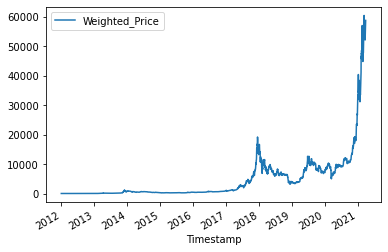

In [16]:
btc_daily.plot()

## Check for stationarity

### 1. Using seasonal_decompse

In [17]:
import statsmodels.api as sm

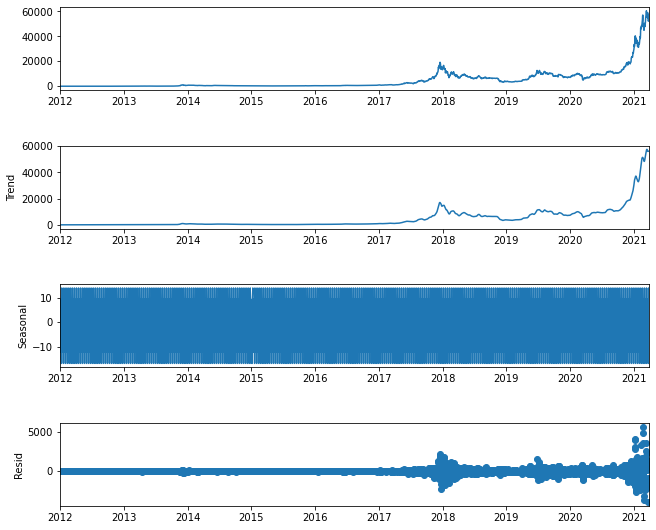

In [18]:
# Seasonal Decomposition
# observed = trend + seasonal + resid
# period(=freq): use to check seasonality

decomposition = sm.tsa.seasonal_decompose(btc_daily, model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Does data have:  
- Trend? No fixed trend  
- Seasonality? None 
- Residual? No fixed residual

### 2. Using the ACF and PACF

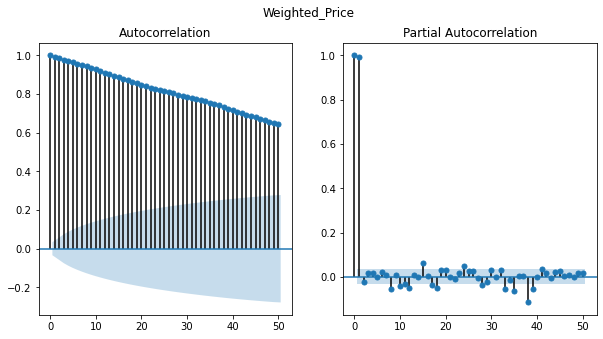

In [19]:
# Plot acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Weighted_Price')
sm.graphics.tsa.plot_acf(btc_daily.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(btc_daily.squeeze(), lags=50, ax=ax[1]);

The ACF tails off slowly (while PACF cuts off after lag 1) so the data is non-stationary.

### 3. Using the augment Dicky-Fuller

In [20]:
from statsmodels.tsa.stattools import adfuller

In [21]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(btc_daily['Weighted_Price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: 6.185633110386281
p-value: 1.0
critical values: {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


Since the ADF statistics is higher than the T-values, 6.18 > -3.43, -2.86, -2.56, null hypothesis cannot be rejected.  
Also, p-value of 1.0 > 0.05 (95% confidence interval), null hypothesis cannot be rejected.  
Hence, the data is non-stationary.

## Taking the difference

In order to make the data stationary, I will take the difference on the data.

##### 1st order differencing

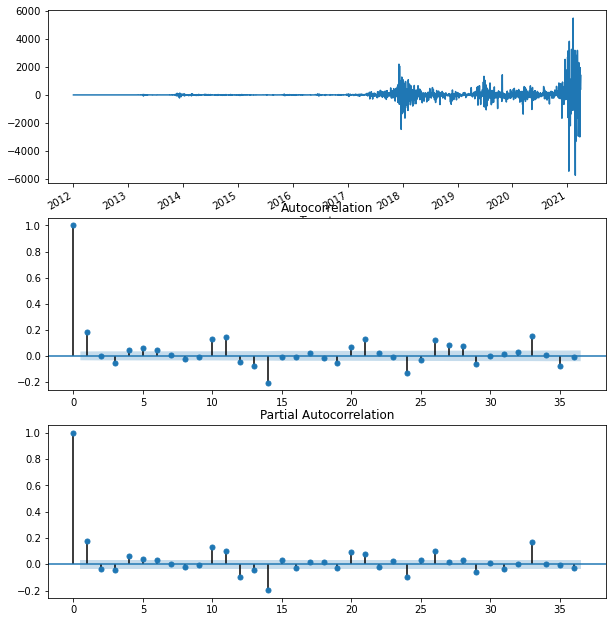

In [22]:
btc_daily_diff_1 = btc_daily.diff(periods=1).dropna()['Weighted_Price']

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
btc_daily_diff_1.plot(ax=ax1)
plot_acf(btc_daily_diff_1, ax=ax2)
plot_pacf(btc_daily_diff_1, ax=ax3)
plt.show()

In [23]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(btc_daily_diff_1)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -9.08653810290712
p-value: 3.926412261826797e-15
critical values: {'1%': -3.4323058648629248, '5%': -2.862404186780598, '10%': -2.5672300237626606}


Since the ADF statistics is lower than the T-values, -9.0865 < -3.43, -2.86, -2.56, null hypothesis can be rejected.  
As well, the p-value of 3.92e-15 < 0.05 (95% confidence interval), null hypothesis can be rejected.

##### 2nd order differencing

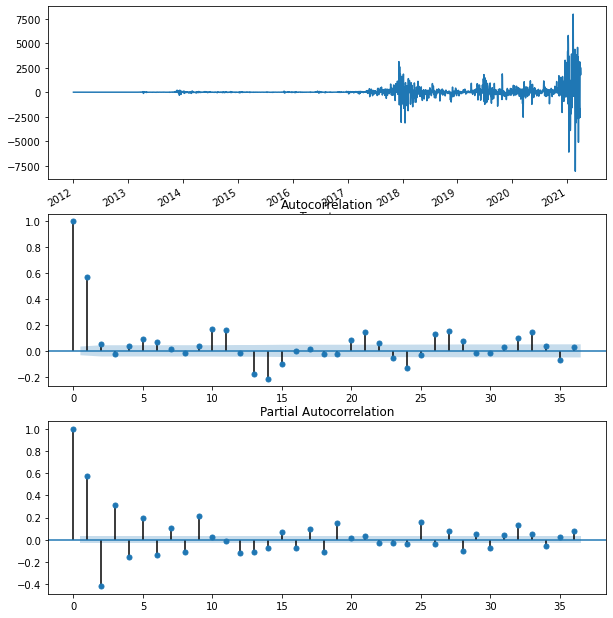

In [24]:
btc_daily_diff_2 = btc_daily.diff(periods=2).dropna()['Weighted_Price']

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
btc_daily_diff_2.plot(ax=ax1)
plot_acf(btc_daily_diff_2, ax=ax2)
plot_pacf(btc_daily_diff_2, ax=ax3)
plt.show()

In [25]:
# Run the ADF test and print the test statistic and the p-value
result = adfuller(btc_daily_diff_2)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -9.29166701035828
p-value: 1.175262057693119e-15
critical values: {'1%': -3.43230703553836, '5%': -2.8624047038663196, '10%': -2.5672302990466394}


It seems taking the 1st order differencing would be enough.  

### Split train-test data

Make the test data with the last one month data

In [26]:
# train_test_split
from sklearn.model_selection import train_test_split
train, test = train_test_split(btc_daily, test_size=(btc_daily.index > '2021-02-28').sum(), shuffle=False, random_state=42)
#train, test = train_test_split(btc_daily, test_size=0.2, shuffle=False, random_state=42)


# Modeling - ARIMA

## Fit to the train data

In [27]:
result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: 5.129896035716514
p-value: 1.0
critical values: {'1%': -3.4323241691940685, '5%': -2.862412271755145, '10%': -2.567234328012212}


As p-value 0.44 > 0.05, take the differencing

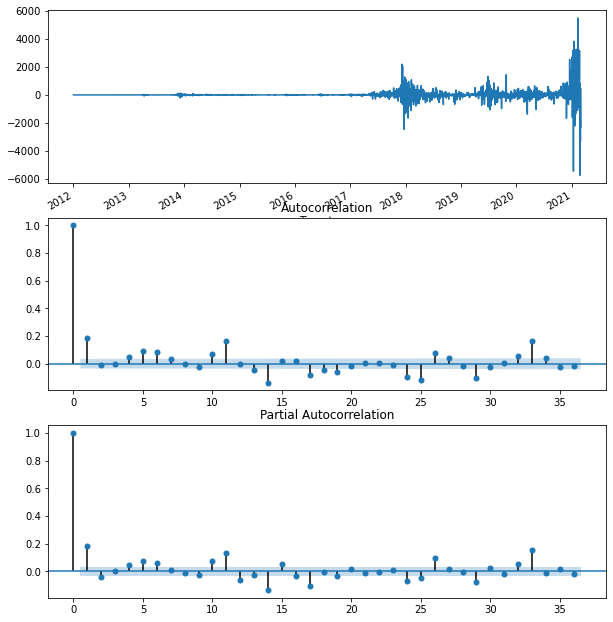

In [28]:
train_diff = train.diff(periods=1).dropna()['Weighted_Price']

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
train_diff.plot(ax=ax1)
plot_acf(train_diff, ax=ax2)
plot_pacf(train_diff, ax=ax3)
plt.show()

In [29]:
result = adfuller(train_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('critical values:', result[4])

ADF Statistic: -12.57243522885284
p-value: 1.9905541811652993e-23
critical values: {'1%': -3.4323241691940685, '5%': -2.862412271755145, '10%': -2.567234328012212}


Find the best combination of (p, d, q)

In [30]:
from statsmodels.tsa.arima_model import ARIMA
import itertools

In [31]:
print("Examples of parameter combinations for seasonal ARIMA")
p=range(0,3)
d=range(1,2)
q=range(0,3)
pdq = list(itertools.product(p,d,q)) 

aic = []
for i in pdq:
    model=ARIMA(train.dropna().values, order=(i))
    model_fit = model.fit(trend='c', full_output=True, disp=True)
    print(f"ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}")
    aic.append(round(model_fit.aic, 2))

Examples of parameter combinations for seasonal ARIMA
ARIMA : (0, 1, 0) >> AIC : 48394.14
ARIMA : (0, 1, 1) >> AIC : 48273.89
ARIMA : (0, 1, 2) >> AIC : 48275.83
ARIMA : (1, 1, 0) >> AIC : 48279.95
ARIMA : (1, 1, 1) >> AIC : 48275.84
ARIMA : (1, 1, 2) >> AIC : 48277.81
ARIMA : (2, 1, 0) >> AIC : 48275.65
ARIMA : (2, 1, 1) >> AIC : 48277.56
ARIMA : (2, 1, 2) >> AIC : 48279.04


In [32]:
optimal = [pdq[np.argmin(aic)], min(aic)]
optimal

[(0, 1, 1), 48273.89]

In [33]:
arima_opt = ARIMA(train.values, order = optimal[0])
arima_opt_fit = arima_opt.fit(trend='c', full_output=True, disp=True)
arima_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 3344
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -24133.945
Method:                       css-mle   S.D. of innovations            329.687
Date:                Mon, 01 Nov 2021   AIC                          48273.890
Time:                        00:06:18   BIC                          48292.235
Sample:                             1   HQIC                         48280.452
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.2469      6.816      1.944      0.052      -0.111      26.605
ma.L1.D.y      0.1955      0.017     11.379      0.000       0.162       0.229
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -5.1150           +0.0000j            5.1150            0.5000
-----------------------------------------------------------------------------
"""

## Predict

In [34]:
# use model to forecast
pred = arima_opt_fit.forecast(steps=test.shape[0])
pred_val = pred[0]
pred_lb = pred[2][:,0]
pred_ub = pred[2][:,1]
pred_index = list(test.index)

forecast will return [predicted_value, stderr, lower_bound, upper_bound]

In [35]:
from sklearn.metrics import r2_score
r2 = r2_score(test, pred_val)
r2

-7.3966339468426305

In [36]:
start = test.index[0]

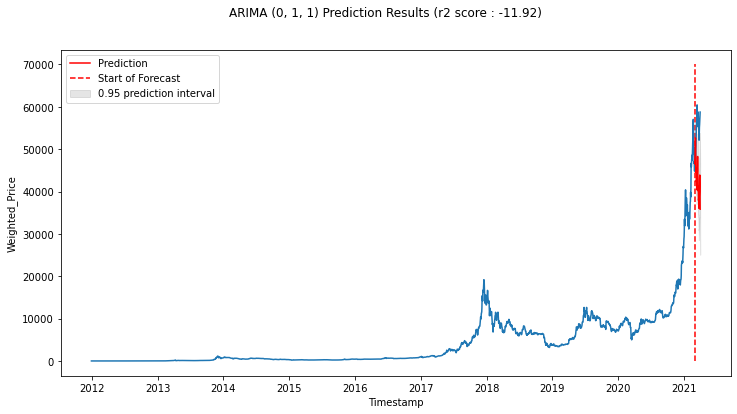

In [54]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price',ax=ax)
ax.vlines(start, 0, 70000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, color='red', label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 prediction interval')
plt.suptitle(f"ARIMA {optimal[0][0]} Prediction Results (r2 score : {round(r2,2)})")
plt.legend(loc='upper left')
plt.show()

Zoom in the date range to see more specifically

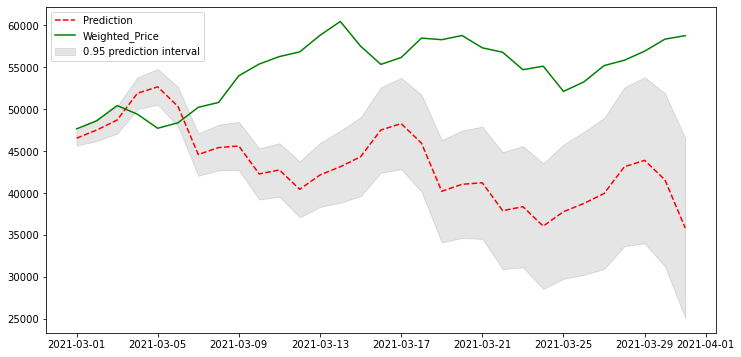

In [53]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pred_index, pred_val, linestyle='--', label='Prediction',color='red')
ax.plot(btc_daily[pred_index[0]:].index, btc_daily[pred_index[0]:], label='Weighted_Price', color='green')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 prediction interval')
plt.legend(loc='upper left')
plt.show()

# Modeling - SARIMAX

## Fit

In [39]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
# SARIMA
# parameter search
print("Examples of parameter combinataions for Seasonal ARIMA")
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []

for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train.values, order = (i), seasoanl_order = (j))
            model_fit = model.fit()
            print(f"SARIMA : {i}{j} >> AIC {round(model_fit.aic, 2)}")
            aic.append(round(model_fit.aic, 2))
            params.append((i, j))
        except:
            pass

Examples of parameter combinataions for Seasonal ARIMA
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC 48397.47
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC 48397.47
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC 48275.66
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC 48275.66
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC 48277.66
SARIMA : (0, 1, 2)(0, 1, 1, 12) >

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMA : (1, 1, 2)(0, 1, 0, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(0, 1, 1, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(0, 1, 2, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(1, 1, 0, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(1, 1, 1, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(1, 1, 2, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(2, 1, 0, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(2, 1, 1, 12) >> AIC 48279.68
SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC 48279.68
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC 48277.54
SARIMA : (2, 1, 0)(2, 1, 2, 12) >> AIC 48277.54
SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC 48279.43
SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC 48279.43
SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC 4

In [41]:
optimal = [params[np.argmin(aic)], min(aic)]
optimal

[((0, 1, 1), (0, 1, 0, 12)), 48275.66]

In [42]:
sarimax_opt = SARIMAX(train.values, order=optimal[0][0], seasonal_order = optimal[0][1])
sarimax_opt_fit = sarimax_opt.fit()
sarimax_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 3345
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood              -25080.351
Date:                             Mon, 01 Nov 2021   AIC                          50164.702
Time:                                     00:06:41   BIC                          50176.925
Sample:                                          0   HQIC                         50169.075
                                            - 3345                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1022      0.005     21.573      0.000       0.093       0.112
sigma2      2.023e+05    836.082    241.927      0.000    2.01e+05    2.04e+05
===================================================================================
Ljung-Box (Q):                     1171.32   Jarque-Bera (JB):            651882.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             796.99   Skew:                            -2.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# use model to forecast
pred = sarimax_opt_fit.get_forecast(steps=test.shape[0])
pred_val = pred.predicted_mean
print(pred_val)

[46532.69493944 47512.08198191 48702.64990949 51890.05933837
 52659.59674452 50327.0828258  44587.6087466  45419.05566957
 45604.00561564 42274.69084921 42748.97886085 40437.21835279
 42151.46574013 43130.8527826  44321.42071018 47508.83013906
 48278.36754521 45945.85362648 40206.37954729 41037.82647026
 41222.77641633 37893.4616499  38367.74966154 36055.98915348
 37770.23654082 38749.62358328 39940.19151086 43127.60093974
 43897.1383459  41564.62442717 35825.15034797]


In [44]:
pred_lb = pred.conf_int()[:,0]
pred_ub = pred.conf_int()[:,1]
pred_index = list(test.index)

In [45]:
r2 = r2_score(test, pred_val)
r2

-11.924116205329305

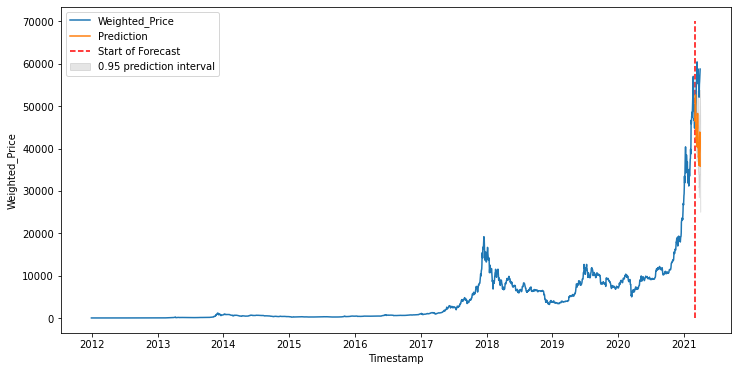

In [46]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=btc_daily, x=btc_daily.index, y='Weighted_Price', label='Weighted_Price')
ax.vlines(start, 0, 70000, linestyle='--', color='red', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.show()

Zoom in the date range to see more specifically

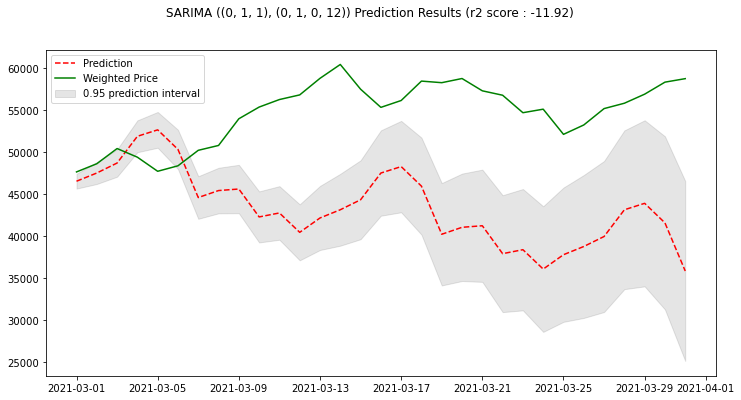

In [50]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(pred_index, pred_val, linestyle='--', label='Prediction', color='red')
ax.plot(btc_daily[pred_index[0]:].index, btc_daily[pred_index[0]:], label='Weighted Price', color='green')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 prediction interval')
plt.suptitle(f"SARIMA {optimal[0]} Prediction Results (r2 score : {round(r2,2)})")
plt.legend(loc='upper left')
plt.show()

# Modeling - Facebook Prophet

In [48]:
!pip3 install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  ERROR: Command errored out with exit status 1:
   command: /opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-huf91unq/fbprophet/setup.py'"'"'; __file__='"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-huf91unq/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-wheel-6jjces4c
       cwd: /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-huf91unq/fbprophet/
  Complete output (38 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):


Failed to build fbprophet
    Running setup.py install for fbprophet ... error
    ERROR: Command errored out with exit status 1:
     command: /opt/anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-huf91unq/fbprophet/setup.py'"'"'; __file__='"'"'/private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-huf91unq/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-record-lamm8o_f/install-record.txt --single-version-externally-managed --compile --install-headers /opt/anaconda3/include/python3.8/fbprophet
         cwd: /private/var/folders/gh/k3x0cnl91zj4r9tfpv2l7tlr0000gn/T/pip-install-huf91unq/fbprophet/
    Complete output (40 lines):
    running install
    running bui

In [49]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'